# Consumer Sector Portfolio Optimization

**Analyst:** Anurag Pokala  
**Date:** January 23, 2026

## Overview

This notebook implements two portfolio optimization techniques for the Consumer sector sleeve:
1. **Mean-Variance (Markowitz) Optimization**
2. **Black-Litterman Optimization**

## Section 1: Setup and Configuration

In [1]:
# Import libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
warnings.filterwarnings('ignore')

# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

# Add src to path
sys.path.insert(0, os.path.abspath('..'))

# Import custom modules
from src import data_loader, estimators, constraints, mv_optimizer, bl_model, metrics, reporting, backtester

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
# Load configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Extract key parameters
tickers = config['tickers']
before_weights = np.array([config['before_weights'][t] for t in tickers])
start_date = config['data']['start_date']
end_date = config['data']['end_date']
rf = config['risk_free_rate']

print("Configuration Loaded:")
print(f"  Tickers: {', '.join(tickers)}")
print(f"  Date range: {start_date} to {end_date}")
print(f"  Risk-free rate: {rf:.2%}")
print(f"\nBefore Portfolio Weights:")
for ticker, weight in zip(tickers, before_weights):
    print(f"  {ticker}: {weight:.2%}")
print(f"\nConstraints:")
print(f"  Long-only: {config['constraints']['long_only']}")
print(f"  Fully invested: {config['constraints']['fully_invested']}")
print(f"  Max weight: {config['constraints']['max_weight']:.0%}")

Configuration Loaded:
  Tickers: AZO, MAR, MNST, TJX, WMT, XLP, FLUT, AMZN
  Date range: 2023-01-23 to 2026-01-23
  Risk-free rate: 4.50%

Before Portfolio Weights:
  AZO: 9.40%
  MAR: 12.67%
  MNST: 15.23%
  TJX: 18.07%
  WMT: 14.40%
  XLP: 8.11%
  FLUT: 10.14%
  AMZN: 11.98%

Constraints:
  Long-only: True
  Fully invested: True
  Max weight: 20%


## Section 2: Data Loading and Preprocessing

Load 3 years of daily price data and compute returns.

In [3]:
# Load price data
prices = data_loader.load_prices(tickers, start_date, end_date)

# Display first and last few rows
print("\nFirst 5 days:")
print(prices.head())
print("\nLast 5 days:")
print(prices.tail())

Date range: 2023-01-23 to 2026-01-23
Successfully loaded 753 trading days of data
Date range: 2023-01-23 to 2026-01-22

First 5 days:
Ticker            AMZN          AZO        FLUT         MAR       MNST  \
Date                                                                     
2023-01-23   97.519997  2318.959961  153.020004  164.006866  50.055000   
2023-01-24   96.320000  2341.560059  163.000000  164.598740  51.509998   
2023-01-25   97.180000  2357.810059  155.000000  167.218689  51.759998   
2023-01-26   99.220001  2415.270020  157.375000  169.401947  51.955002   
2023-01-27  102.239998  2369.340088  151.229996  169.159348  51.395000   

Ticker            TJX        WMT        XLP  
Date                                         
2023-01-23  75.948769  45.838871  67.192810  
2023-01-24  77.992119  45.960987  67.469521  
2023-01-25  79.287186  45.742474  67.635551  
2023-01-26  79.104919  45.700695  67.395721  
2023-01-27  78.558105  46.050968  67.202034  

Last 5 days:
Ticker     

In [4]:
# Compute returns
returns = data_loader.compute_returns(prices, method='log')

# Summary statistics
stats = data_loader.get_summary_statistics(returns)
print("\nReturns Summary Statistics:")
print(stats.round(4))


Returns Summary (log returns):
Shape: (752, 8)
Date range: 2023-01-24 to 2026-01-22

Returns Summary Statistics:
        Daily Mean  Daily Std  Annual Mean  Annual Vol  Sharpe (Ann, rf=0)  \
Ticker                                                                       
AMZN        0.0012     0.0199       0.2938      0.3162              0.9292   
AZO         0.0006     0.0137       0.1564      0.2182              0.7171   
FLUT        0.0002     0.0245       0.0566      0.3884              0.1458   
MAR         0.0009     0.0158       0.2257      0.2500              0.9028   
MNST        0.0006     0.0143       0.1608      0.2265              0.7100   
TJX         0.0009     0.0107       0.2356      0.1692              1.3922   
WMT         0.0013     0.0125       0.3164      0.1983              1.5955   
XLP         0.0003     0.0074       0.0678      0.1168              0.5806   

           Min     Max  Skewness  Kurtosis  
Ticker                                      
AMZN   -0.0941 

Saved cumulative returns plot to ../outputs/cumulative_returns.png


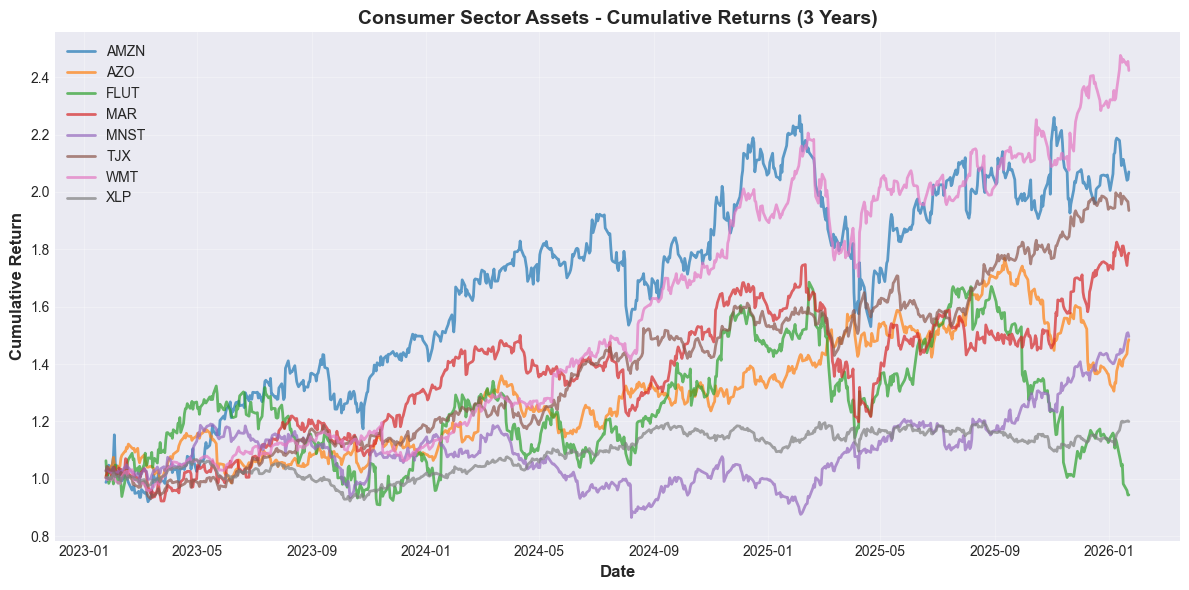

In [5]:
# Plot cumulative returns
fig = reporting.plot_cumulative_returns(
    returns,
    output_path='../outputs/cumulative_returns.png',
    title='Consumer Sector Assets - Cumulative Returns (3 Years)'
)
plt.show()

In [6]:
# Data quality check
passed, diagnostics = data_loader.check_data_quality(prices, returns)
print(f"\nData quality check: {'PASSED' if passed else 'FAILED'}")
print(f"Diagnostics:")
for key, value in diagnostics.items():
    print(f"  {key}: {value}")


Data quality check: PASSED
Diagnostics:
  missing_pct: {'AMZN': 0.0, 'AZO': 0.0, 'FLUT': 0.0, 'MAR': 0.0, 'MNST': 0.0, 'TJX': 0.0, 'WMT': 0.0, 'XLP': 0.0}
  missing_check: PASSED
  extreme_returns: {'AMZN': 0, 'AZO': 0, 'FLUT': 0, 'MAR': 0, 'MNST': 0, 'TJX': 0, 'WMT': 0, 'XLP': 0}
  data_length_check: PASSED (752 days)


## Section 3: Covariance and Returns Estimation

Use robust estimation techniques to reduce noise in small samples.

In [7]:
# Estimate covariance using Ledoit-Wolf shrinkage
Sigma, shrinkage_intensity = estimators.estimate_covariance_shrinkage(
    returns,
    method='ledoit_wolf'
)

print(f"\nAnnualized Covariance Matrix:")
print(Sigma.round(4))

Ledoit-Wolf shrinkage intensity: 0.0377
Annualized covariance matrix estimated (shape: (8, 8))
Volatility range: 12.43% to 38.38%

Annualized Covariance Matrix:
Ticker    AMZN     AZO    FLUT     MAR    MNST     TJX     WMT     XLP
Ticker                                                                
AMZN    0.0984  0.0016  0.0343  0.0319  0.0081  0.0125  0.0128  0.0031
AZO     0.0016  0.0481  0.0068  0.0101  0.0105  0.0120  0.0078  0.0089
FLUT    0.0343  0.0068  0.1473  0.0312  0.0032  0.0124  0.0101  0.0050
MAR     0.0319  0.0101  0.0312  0.0624  0.0099  0.0158  0.0116  0.0082
MNST    0.0081  0.0105  0.0032  0.0099  0.0516  0.0096  0.0092  0.0127
TJX     0.0125  0.0120  0.0124  0.0158  0.0096  0.0298  0.0126  0.0089
WMT     0.0128  0.0078  0.0101  0.0116  0.0092  0.0126  0.0401  0.0124
XLP     0.0031  0.0089  0.0050  0.0082  0.0127  0.0089  0.0124  0.0154


In [8]:
# Estimate expected returns (historical mean)
mu_hist = estimators.estimate_expected_returns(
    returns,
    shrinkage=config['mean_variance']['returns_shrinkage']
)

print("\nExpected Returns (Annualized):")
for ticker, ret in zip(tickers, mu_hist):
    print(f"  {ticker}: {ret:.2%}")

Using pure historical mean returns (no shrinkage)
Expected returns range: 5.66% to 31.64%

Expected Returns (Annualized):
  AZO: 29.38%
  MAR: 15.64%
  MNST: 5.66%
  TJX: 22.57%
  WMT: 16.08%
  XLP: 23.56%
  FLUT: 31.64%
  AMZN: 6.78%


In [9]:
# Correlation matrix
corr = estimators.get_correlation_matrix(Sigma)

print("\nCorrelation Matrix:")
print(corr.round(3))


Correlation Matrix:
Ticker   AMZN    AZO   FLUT    MAR   MNST    TJX    WMT    XLP
Ticker                                                        
AMZN    1.000  0.023  0.285  0.407  0.114  0.231  0.203  0.080
AZO     0.023  1.000  0.080  0.184  0.210  0.316  0.178  0.328
FLUT    0.285  0.080  1.000  0.326  0.037  0.188  0.131  0.104
MAR     0.407  0.184  0.326  1.000  0.174  0.365  0.231  0.264
MNST    0.114  0.210  0.037  0.174  1.000  0.244  0.203  0.451
TJX     0.231  0.316  0.188  0.365  0.244  1.000  0.363  0.415
WMT     0.203  0.178  0.131  0.231  0.203  0.363  1.000  0.499
XLP     0.080  0.328  0.104  0.264  0.451  0.415  0.499  1.000


Saved correlation heatmap to ../outputs/correlation_heatmap.png


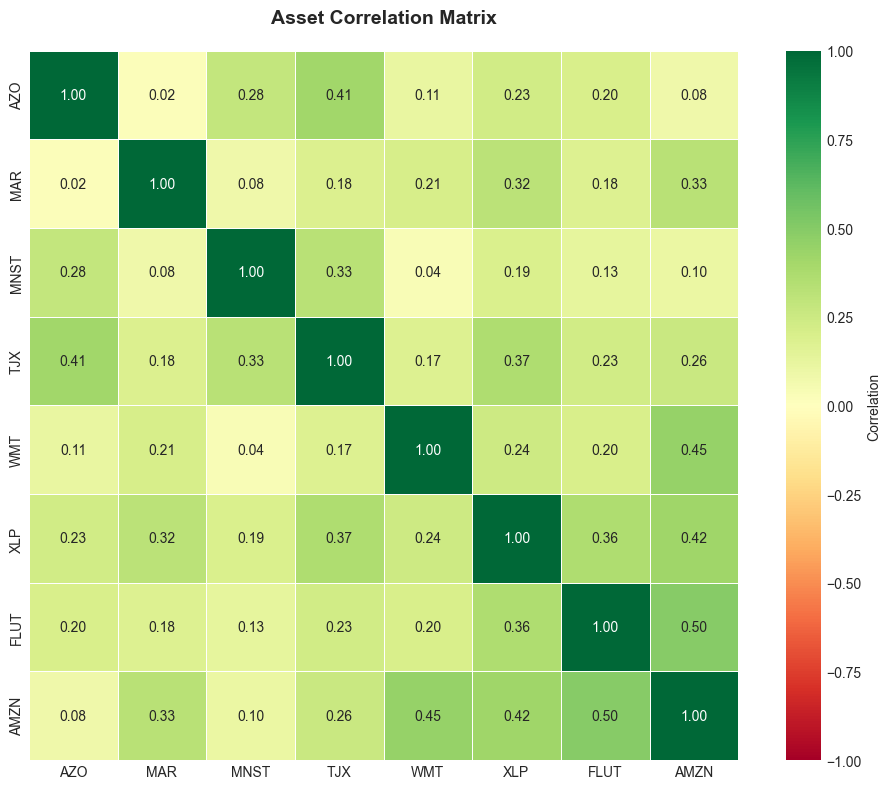

In [10]:
# Plot correlation heatmap
fig = reporting.plot_correlation_heatmap(
    Sigma.values,
    tickers,
    output_path='../outputs/correlation_heatmap.png'
)
plt.show()

In [11]:
# Validate covariance matrix
is_valid, cov_diagnostics = estimators.validate_covariance_matrix(Sigma.values)
print(f"\nCovariance matrix validation: {'PASSED' if is_valid else 'FAILED'}")
print(f"  Min eigenvalue: {cov_diagnostics['min_eigenvalue']:.6f}")
print(f"  Condition number: {cov_diagnostics['condition_number']:.2f}")


Covariance matrix validation: PASSED
  Min eigenvalue: 0.007733
  Condition number: 24.53


## Section 4: Mean-Variance Optimization

### Primer: Mean-Variance (Markowitz) Optimization

#### Objective Function
Mean-Variance optimization seeks portfolio weights that optimize the tradeoff between expected return and risk (variance):

$$\min_{w} \quad \frac{1}{2} w^T \Sigma w - \lambda \mu^T w$$

subject to:
- $\sum w_i = 1$ (fully invested)
- $w_i \geq 0$ (long-only)
- $w_i \leq w_{\max}$ (position limits)

where:
- $w$ = portfolio weights
- $\mu$ = expected returns
- $\Sigma$ = covariance matrix
- $\lambda$ = risk aversion parameter (higher $\lambda$ → more weight on returns)

#### Key Assumptions
1. **Normally distributed returns**: Asset returns follow a multivariate normal distribution
2. **Stable parameters**: Expected returns and covariances are constant over time
3. **Mean-variance utility**: Investors care only about mean and variance, not higher moments
4. **Historical estimates are unbiased**: Past returns predict future returns

#### Strengths
- Mathematically rigorous and theoretically sound
- Provides clear risk-return tradeoff
- Forms efficient frontier showing optimal portfolios
- Well-understood and widely used

#### Weaknesses
- **Extremely sensitive to return estimates**: Small errors in $\mu$ lead to large portfolio changes ("estimation error maximization")
- **Unstable over time**: Optimal weights can fluctuate wildly as new data arrives
- **Concentrated portfolios**: Often produces extreme weights on a few assets
- **Poor out-of-sample performance**: Tends to underperform naive strategies due to overfitting

#### Macro Regimes Where It Works Well
- **Stable, low-volatility periods**: When historical relationships hold and volatility is predictable
- **Mean-reverting markets**: Returns exhibit mean reversion, making historical averages informative
- **Established economic regime**: No structural breaks or regime changes

#### Macro Regimes Where It Struggles
- **Regime transitions**: Inflation shifts, rate cycles, or economic turning points invalidate historical data
- **High uncertainty**: When volatility spikes or correlations break down
- **Structural changes**: New competitive dynamics, regulatory shifts, or technological disruption

#### Application to Consumer Sector
The consumer sector is **challenging for pure Mean-Variance** because:
- **Cyclical vs defensive split**: Discretionary (MAR, AMZN) vs staples (WMT, XLP) behave differently across cycles
- **Current macro uncertainty**: Sticky inflation, elevated rates, and shifting consumer behavior create regime uncertainty
- **Historical relationships may not hold**: Post-pandemic consumption patterns differ from pre-2020 trends

For these reasons, we'll use **robust estimation** (Ledoit-Wolf shrinkage) and compare results to Black-Litterman, which incorporates forward-looking views.

In [12]:
# Run Mean-Variance optimization
mv_results = mv_optimizer.optimize_mean_variance(
    mu=mu_hist.values,
    Sigma=Sigma.values,
    constraints_config=config['constraints'],
    rf=rf,
    lambda_grid=np.logspace(
        np.log10(config['mean_variance']['lambda_min']),
        np.log10(config['mean_variance']['lambda_max']),
        config['mean_variance']['lambda_points']
    ),
    w_before=before_weights
)

w_mv = mv_results['weights']

print("\nMean-Variance Optimal Weights:")
for ticker, weight in zip(tickers, w_mv):
    print(f"  {ticker}: {weight:.2%}")


Mean-Variance Optimization
Number of assets: 8
Expected returns: 5.66% to 31.64%
Volatilities: 12.43% to 38.38%

Sweeping 30 risk-aversion parameters...

Optimization Complete
Efficient frontier computed: 30 portfolios
Best lambda (risk aversion): 0.1000
Expected return: 23.84%
Expected volatility: 13.69%
Sharpe ratio: 1.4126

Mean-Variance Optimal Weights:
  AZO: 18.60%
  MAR: 16.30%
  MNST: 0.00%
  TJX: 11.56%
  WMT: 13.53%
  XLP: 20.00%
  FLUT: 20.00%
  AMZN: -0.00%


In [13]:
# Compute MV portfolio metrics
mv_metrics = metrics.compute_portfolio_metrics(
    w_mv, mu_hist.values, Sigma.values, rf, before_weights, tickers
)

print("\nMean-Variance Portfolio Metrics:")
print(f"  Expected Annual Return:     {mv_metrics['expected_annual_return']:.2%}")
print(f"  Expected Annual Volatility: {mv_metrics['expected_annual_volatility']:.2%}")
print(f"  Sharpe Ratio:               {mv_metrics['sharpe_ratio']:.4f}")
print(f"  Risk-Adjusted Return:       {mv_metrics['risk_adjusted_return']:.4f}")
print(f"  Diversification Ratio:      {mv_metrics['diversification_ratio']:.4f}")
print(f"  Effective # Assets:         {mv_metrics['effective_n_assets']:.2f}")
print(f"  Turnover vs Before:         {mv_metrics['turnover']:.2%}")


Mean-Variance Portfolio Metrics:
  Expected Annual Return:     23.84%
  Expected Annual Volatility: 13.69%
  Sharpe Ratio:               1.4126
  Risk-Adjusted Return:       1.4126
  Diversification Ratio:      1.6676
  Effective # Assets:         5.78
  Turnover vs Before:         69.18%


Saved efficient frontier plot to ../outputs/efficient_frontier.png


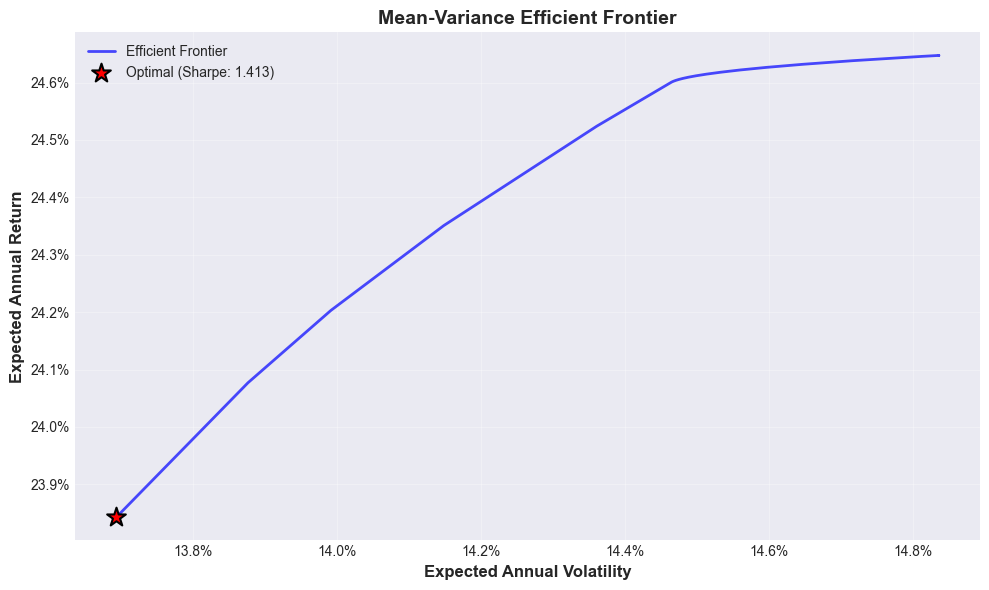

In [14]:
# Plot efficient frontier
fig = reporting.plot_efficient_frontier(
    mv_results['frontier'],
    optimal_point={
        'volatility': mv_results['volatility'],
        'return': mv_results['return'],
        'sharpe': mv_results['sharpe']
    },
    output_path='../outputs/efficient_frontier.png'
)
plt.show()

In [15]:
# Risk decomposition for MV portfolio
mv_risk_decomp = metrics.compute_risk_decomposition(w_mv, Sigma.values, tickers)
print("\nMean-Variance Portfolio - Risk Decomposition:")
print(mv_risk_decomp.round(4))


Mean-Variance Portfolio - Risk Decomposition:
  Ticker  Weight  Individual Vol    MCTR    CCTR  % Contribution
0    AZO  0.1860          0.3137  0.2075  0.0386          0.2819
1    MAR  0.1630          0.2192  0.1072  0.0175          0.1276
2   MNST  0.0000          0.3838  0.1171  0.0000          0.0000
3    TJX  0.1156          0.2498  0.1578  0.0182          0.1332
4    WMT  0.1353          0.2272  0.1104  0.0149          0.1090
5    XLP  0.2000          0.1728  0.1160  0.0232          0.1694
6   FLUT  0.2000          0.2003  0.1225  0.0245          0.1789
7   AMZN -0.0000          0.1243  0.0655 -0.0000         -0.0000


In [16]:
# Validate MV constraints
is_valid, violations = constraints.validate_weights(
    w_mv, config['constraints'], before_weights
)
print(f"\nMV Constraint Validation: {'PASSED' if is_valid else 'FAILED'}")
if violations:
    for key, msg in violations.items():
        print(f"  {key}: {msg}")


MV Constraint Validation: PASSED


## Section 5: Black-Litterman Optimization

### Primer: Black-Litterman Model

#### Objective Function
Black-Litterman improves on Mean-Variance by starting from an equilibrium "prior" and blending in analyst "views" to produce stable posterior expected returns:

$$\mu_{BL} = \left[(\tau\Sigma)^{-1} + P^T\Omega^{-1}P\right]^{-1} \left[(\tau\Sigma)^{-1}\pi + P^T\Omega^{-1}q\right]$$

where:
- $\pi = \delta \Sigma w_{market}$ = equilibrium (prior) returns
- $P$ = view matrix (picks out assets in views)
- $q$ = view returns (analyst expectations)
- $\Omega$ = view confidence matrix (diagonal, lower values = higher confidence)
- $\tau$ = uncertainty scaling parameter (typically 0.01-0.05)
- $\delta$ = risk aversion parameter (typically 2-4)

After computing posterior returns $\mu_{BL}$, optimize using standard mean-variance.

#### Key Assumptions
1. **Market equilibrium**: Current portfolio weights reflect market consensus (equilibrium)
2. **Bayesian framework**: Posterior returns are a weighted blend of prior and views
3. **Analyst views are informative**: Deviations from equilibrium have predictive power
4. **View uncertainty is quantifiable**: Confidence levels can be expressed as variances

#### Strengths
- **Reduces estimation error**: Anchors to equilibrium rather than noisy historical means
- **Incorporates forward-looking views**: Uses analyst insights about future conditions
- **More stable portfolios**: Less sensitive to data noise, smoother weight changes
- **Intuitive framework**: Naturally blends quantitative and qualitative inputs
- **Flexible**: Can express absolute or relative views with varying confidence

#### Weaknesses
- **Requires careful view specification**: Garbage views in → garbage portfolio out
- **Equilibrium assumption**: May not hold during market dislocations or regime shifts
- **Parameter sensitivity**: Results depend on $\tau$, $\delta$, and $\Omega$ choices
- **Complexity**: More moving parts than pure Mean-Variance
- **Anchoring bias**: Strong prior can prevent sufficient response to new information

#### Macro Regimes Where It Works Well
- **Regime transitions**: When historical data is stale but analyst has forward-looking insights
- **Structural changes**: Analyst views on new competitive dynamics, regulatory shifts
- **Differentiated insights**: When analyst has edge on specific names or relationships
- **Moderate uncertainty**: Some signal in views, not complete chaos

#### Macro Regimes Where It Struggles
- **Extreme market stress**: When equilibrium assumption breaks down entirely
- **Poor view quality**: If analyst views are systematically biased or uninformed
- **Very stable regime**: Pure historical mean-variance may suffice
- **Liquidity crises**: Market weights become distorted by forced selling

#### Application to Consumer Sector
Black-Litterman is **well-suited for consumer sector** in current environment:
- **Forward-looking macro views**: Can incorporate expectations about inflation, rates, consumer spending
- **Discretionary vs staples tilt**: Views express preference for defensive (staples) vs cyclical (discretionary)
- **Company-specific insights**: Lead analyst has differentiated views on FLUT (bearish), AMZN/WMT (bullish)
- **Regime uncertainty**: Current macro is transitional, making historical data less reliable

We'll encode the **lead analyst's qualitative views** into quantitative $P$, $q$, $\Omega$ matrices.

### Lead Analyst Views Summary

From the investment club sector lead:

**Bullish:**
- **AMZN, WMT**: "Will continue to flourish" → Strong positive view
- **AZO, TJX**: "Good" picks; AZO benefits from weak auto industry; TJX is solid trade-down play → Moderate positive
- **MNST**: "Remain steady" with health/wellness tailwind → Moderate positive

**Bearish:**
- **FLUT**: "Not a fan", curious to see outlook → Strong negative
- **MAR**: "Meh", sensitive to travel demand/inflation/CPI → Moderate negative

**Neutral-to-Positive:**
- **XLP**: Implied positive on staples given macro environment → Small positive

These views will be translated into **absolute expected return adjustments** relative to equilibrium.

In [17]:
# Step 1: Compute equilibrium (prior) returns
delta = config['black_litterman']['delta']
pi = bl_model.compute_equilibrium_returns(
    Sigma.values,
    before_weights,
    delta
)

print("\nEquilibrium Returns (Prior):")
for ticker, ret in zip(tickers, pi):
    print(f"  {ticker}: {ret:.2%}")


Equilibrium (Prior) Returns:
  Risk aversion (delta): 2.5
  Equilibrium returns: 2.33% to 8.81%
  Mean equilibrium return: 4.68%

Equilibrium Returns (Prior):
  AZO: 6.07%
  MAR: 3.36%
  MNST: 8.81%
  TJX: 6.29%
  WMT: 3.76%
  XLP: 3.39%
  FLUT: 3.43%
  AMZN: 2.33%


In [18]:
# Step 2: Encode analyst views
views_config = config['black_litterman']['views']
P, q, Omega = bl_model.encode_views(tickers, views_config, len(tickers))

print("\nView Matrix P (picks):")
print(pd.DataFrame(P, columns=tickers).round(2))
print("\nView Returns q:")
print(q)
print("\nView Confidence Omega (diagonal):")
print(np.diag(Omega))


Encoding 7 analyst views:
  1. AMZN: absolute return = +4.00%, confidence σ² = 0.000400
  2. WMT: absolute return = +3.00%, confidence σ² = 0.000400
  3. FLUT: absolute return = -4.00%, confidence σ² = 0.000400
  4. MAR: absolute return = -2.00%, confidence σ² = 0.000900
  5. AZO: absolute return = +2.50%, confidence σ² = 0.000900
  6. TJX: absolute return = +2.50%, confidence σ² = 0.000900
  7. MNST: absolute return = +1.50%, confidence σ² = 0.000900

View Matrix P (picks):
   AZO  MAR  MNST  TJX  WMT  XLP  FLUT  AMZN
0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   1.0
1  0.0  0.0   0.0  0.0  1.0  0.0   0.0   0.0
2  0.0  0.0   0.0  0.0  0.0  0.0   1.0   0.0
3  0.0  1.0   0.0  0.0  0.0  0.0   0.0   0.0
4  1.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0
5  0.0  0.0   0.0  1.0  0.0  0.0   0.0   0.0
6  0.0  0.0   1.0  0.0  0.0  0.0   0.0   0.0

View Returns q:
[ 0.04   0.03  -0.04  -0.02   0.025  0.025  0.015]

View Confidence Omega (diagonal):
[0.0004 0.0004 0.0004 0.0009 0.0009 0.0009 0.0009]


In [19]:
# Step 3: Compute Black-Litterman posterior returns
tau = config['black_litterman']['tau']
mu_BL, Sigma_BL = bl_model.compute_bl_posterior(
    pi, Sigma.values, P, q, Omega, tau
)

print("\nBlack-Litterman Posterior Returns:")
for ticker, ret in zip(tickers, mu_BL):
    print(f"  {ticker}: {ret:.2%}")


Black-Litterman Posterior:
  Tau (uncertainty scaling): 0.05
  Posterior returns: -2.53% to 3.10%
  Mean posterior return: 1.37%
  Change from prior: -6.73% to -0.09%

Black-Litterman Posterior Returns:
  AZO: 2.49%
  MAR: -0.55%
  MNST: 2.09%
  TJX: 2.84%
  WMT: 3.10%
  XLP: 1.26%
  FLUT: -2.53%
  AMZN: 2.24%


In [20]:
# Analyze view impact
view_impact = bl_model.analyze_view_impact(pi, mu_BL, tickers)
print("\nView Impact Analysis:")
print(view_impact.round(4))


View Impact Analysis:
  Ticker  Prior (π)  Posterior (μ_BL)  Change  Change (%)
0    AZO     0.0607            0.0249 -0.0358    -58.9207
1    MAR     0.0336           -0.0055 -0.0390   -116.2327
2   MNST     0.0881            0.0209 -0.0673    -76.3258
3    TJX     0.0629            0.0284 -0.0345    -54.8931
4    WMT     0.0376            0.0310 -0.0066    -17.6364
5    XLP     0.0339            0.0126 -0.0214    -63.0059
6   FLUT     0.0343           -0.0253 -0.0596   -173.6226
7   AMZN     0.0233            0.0224 -0.0009     -3.7883


Saved view impact plot to ../outputs/bl_view_impact.png


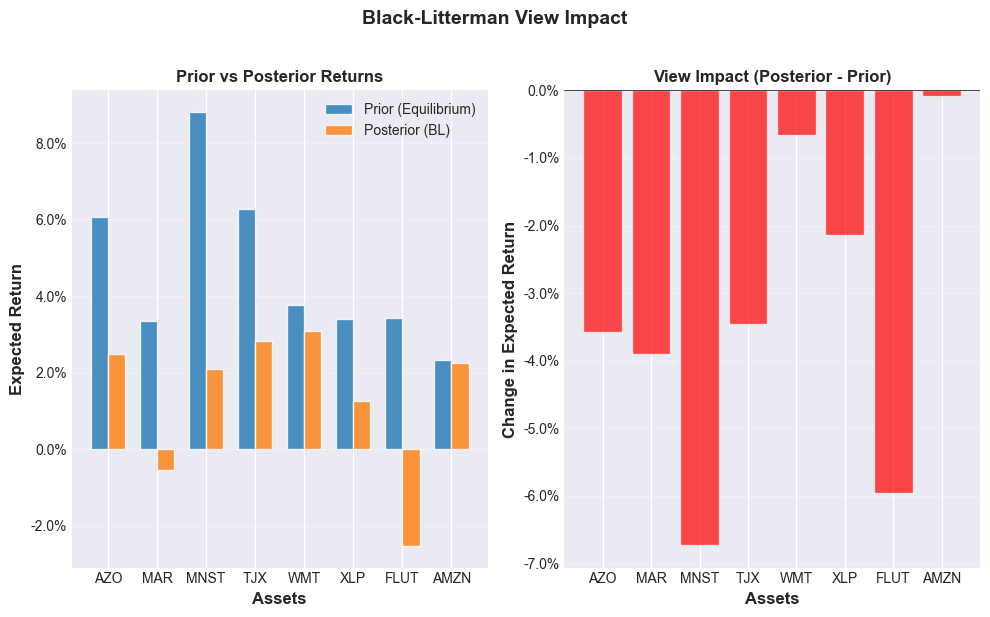

In [21]:
# Plot view impact
fig = reporting.plot_view_impact(
    view_impact,
    output_path='../outputs/bl_view_impact.png'
)
plt.show()

In [22]:
# Step 4: Optimize using BL posterior returns
bl_results = bl_model.optimize_black_litterman(
    pi=pi,
    Sigma=Sigma.values,
    P=P,
    q=q,
    Omega=Omega,
    tau=tau,
    constraints_config=config['constraints'],
    rf=rf,
    w_before=before_weights,
    use_posterior_cov=False  # Use original Sigma for optimization
)

w_bl = bl_results['weights']

print("\nBlack-Litterman Optimal Weights:")
for ticker, weight in zip(tickers, w_bl):
    print(f"  {ticker}: {weight:.2%}")


Black-Litterman Optimization

Black-Litterman Posterior:
  Tau (uncertainty scaling): 0.05
  Posterior returns: -2.53% to 3.10%
  Mean posterior return: 1.37%
  Change from prior: -6.73% to -0.09%

Optimization Complete
Expected return: 2.37%
Expected volatility: 13.82%
Sharpe ratio: -0.1542

Black-Litterman Optimal Weights:
  AZO: 14.90%
  MAR: 0.00%
  MNST: 5.51%
  TJX: 20.00%
  WMT: 20.00%
  XLP: 19.59%
  FLUT: 0.00%
  AMZN: 20.00%


In [23]:
# Compute BL portfolio metrics
bl_metrics = metrics.compute_portfolio_metrics(
    w_bl, mu_BL, Sigma.values, rf, before_weights, tickers
)

print("\nBlack-Litterman Portfolio Metrics:")
print(f"  Expected Annual Return:     {bl_metrics['expected_annual_return']:.2%}")
print(f"  Expected Annual Volatility: {bl_metrics['expected_annual_volatility']:.2%}")
print(f"  Sharpe Ratio:               {bl_metrics['sharpe_ratio']:.4f}")
print(f"  Risk-Adjusted Return:       {bl_metrics['risk_adjusted_return']:.4f}")
print(f"  Diversification Ratio:      {bl_metrics['diversification_ratio']:.4f}")
print(f"  Effective # Assets:         {bl_metrics['effective_n_assets']:.2f}")
print(f"  Turnover vs Before:         {bl_metrics['turnover']:.2%}")


Black-Litterman Portfolio Metrics:
  Expected Annual Return:     2.37%
  Expected Annual Volatility: 13.82%
  Sharpe Ratio:               -0.1542
  Risk-Adjusted Return:       -0.1542
  Diversification Ratio:      1.6060
  Effective # Assets:         5.45
  Turnover vs Before:         65.05%


In [24]:
# Risk decomposition for BL portfolio
bl_risk_decomp = metrics.compute_risk_decomposition(w_bl, Sigma.values, tickers)
print("\nBlack-Litterman Portfolio - Risk Decomposition:")
print(bl_risk_decomp.round(4))


Black-Litterman Portfolio - Risk Decomposition:
  Ticker  Weight  Individual Vol    MCTR    CCTR  % Contribution
0    AZO  0.1490          0.3137  0.1999  0.0298          0.2155
1    MAR  0.0000          0.2192  0.0640  0.0000          0.0000
2   MNST  0.0551          0.3838  0.1704  0.0094          0.0680
3    TJX  0.2000          0.2498  0.1856  0.0371          0.2685
4    WMT  0.2000          0.2272  0.1311  0.0262          0.1896
5    XLP  0.1959          0.1728  0.1103  0.0216          0.1563
6   FLUT  0.0000          0.2003  0.0836  0.0000          0.0000
7   AMZN  0.2000          0.1243  0.0706  0.0141          0.1021


In [25]:
# Validate BL constraints
is_valid, violations = constraints.validate_weights(
    w_bl, config['constraints'], before_weights
)
print(f"\nBL Constraint Validation: {'PASSED' if is_valid else 'FAILED'}")
if violations:
    for key, msg in violations.items():
        print(f"  {key}: {msg}")


BL Constraint Validation: PASSED


## Section 5B: Black-Litterman with Sentiment Analysis

### Primer: Sentiment-Enhanced Black-Litterman

#### Innovation

This approach enhances the traditional Black-Litterman model by incorporating **real-time market sentiment** from financial news alongside manual analyst views. Instead of relying solely on subjective analyst opinions, we augment the process with quantitative sentiment analysis of recent news coverage.

#### How It Works

**Step 1: News Collection (Polygon API)**
- Fetch financial news articles for each stock over the past 30 days
- Polygon provides high-quality, curated financial news from major sources

**Step 2: Sentiment Analysis (FinBERT)**
- Analyze each article using FinBERT, a transformer model specifically trained on financial text
- FinBERT classifies sentiment as positive, negative, or neutral with confidence scores
- Much more accurate than generic sentiment models because it understands financial context

**Step 3: Validation (Finnhub)**
- Cross-reference with Finnhub's aggregate sentiment scores
- Helps catch cases where FinBERT might misclassify due to sarcasm, negation, or complex language
- Increases confidence when both sources agree

**Step 4: Relative Ranking**
- Rank stocks by sentiment score (most positive to most negative)
- Assign expected returns based on quartile:
  - Top 25%: +4% expected return (strong positive sentiment)
  - Second 25%: +2% expected return
  - Third 25%: -1% expected return
  - Bottom 25%: -3% expected return (strong negative sentiment)
- Relative ranking is more robust than absolute scaling

**Step 5: View Blending**
- Combine sentiment views with manual analyst views (50/50 weight)
- When both agree: high confidence
- When they conflict: lower confidence (market may know something analyst doesn't)
- Provides human-in-the-loop validation

#### Why This Matters

**Advantages over Traditional BL:**
- **Objective data**: Reduces pure subjectivity, adds market signal
- **Timely**: Captures recent news that analyst may not have processed yet
- **Systematic**: Eliminates cognitive biases (confirmation bias, anchoring)
- **Scalable**: Can analyze thousands of articles automatically
- **Validation**: Two-source approach (FinBERT + Finnhub) increases reliability

**When It Works Best:**
- High news flow period (earnings season, product launches, regulatory changes)
- Divergence between sentiment and historical performance
- Sector rotation or regime changes
- When you want to validate your own hunches against market signal

**Limitations:**
- News can be noisy or manipulated (pump-and-dump schemes)
- Sentiment may lag actual fundamentals
- Works best with actively-covered stocks (large caps)
- Requires careful calibration of sentiment-to-return mapping

#### Technical Implementation

- **FinBERT Model**: ProsusAI/finbert (440MB, Hugging Face)
- **Batch Processing**: Analyzes 32 articles simultaneously for speed
- **API Cost**: $0 (all free tiers sufficient for 8 stocks)
- **Runtime**: ~30-60 seconds for full analysis

In [26]:
# Import sentiment module and load API keys from .env
from dotenv import load_dotenv
from src import sentiment_analyzer

# Load environment variables
load_dotenv()
polygon_key = os.getenv('POLYGON_API_KEY')
finnhub_key = os.getenv('FINNHUB_API_KEY')

print("✓ Sentiment analyzer loaded")
print(f"✓ API keys loaded from .env")

✓ Sentiment analyzer loaded
✓ API keys loaded from .env


In [27]:
# Run complete sentiment analysis pipeline
# This will:
#   1. Fetch news for each ticker (Polygon)
#   2. Analyze sentiment with FinBERT
#   3. Validate with Finnhub
#   4. Rank stocks by sentiment
#   5. Combine with analyst views

combined_views, sentiment_data, sentiment_summary = sentiment_analyzer.analyze_portfolio_sentiment(
    tickers=tickers,
    config=config,
    polygon_key=polygon_key,
    finnhub_key=finnhub_key
)


SENTIMENT ANALYSIS PIPELINE

Analyzing sentiment for AZO
Fetching news from Polygon (last 30 days)...
  Found 4 articles
  ⚠️  Warning: Only 4 articles (minimum 5 recommended)
  Falling back to Finnhub only

Analyzing sentiment for MAR
Fetching news from Polygon (last 30 days)...
  Found 6 articles
Analyzing sentiment with FinBERT...
Loading FinBERT model: ProsusAI/finbert...
(This may take a minute on first run - model will be cached)
✓ FinBERT model loaded successfully
  FinBERT: 83.3% positive, 0.0% negative
  FinBERT score: +0.833
Validating with Finnhub...
  Finnhub score: +0.000
  Combined score: +0.583 (positive)
  Agreement: weak (confidence: low)

Analyzing sentiment for MNST
Fetching news from Polygon (last 30 days)...
  Found 3 articles
  ⚠️  Warning: Only 3 articles (minimum 5 recommended)
  Falling back to Finnhub only

Analyzing sentiment for TJX
Fetching news from Polygon (last 30 days)...
  Found 8 articles
Analyzing sentiment with FinBERT...
  FinBERT: 50.0% positive,

In [28]:
# Display sentiment analysis summary
print("\nSentiment Analysis Summary:")
print("="*90)
print(sentiment_summary.to_string(index=False))
print("="*90)


Sentiment Analysis Summary:
Ticker  Sentiment Score Sentiment Label Confidence  Articles  Rank  Sentiment View  Analyst View  Combined View
   AZO         0.000000         neutral        low         4     5           -0.01         0.025         0.0075
   MAR         0.583333        positive        low         6     1            0.04        -0.020         0.0100
  MNST         0.000000         neutral        low         3     6           -0.01         0.015         0.0025
   TJX         0.087500         neutral       high         8     4            0.02         0.025         0.0225
   WMT         0.350000        positive        low        62     2            0.04         0.030         0.0350
   XLP         0.000000         neutral        low         4     7           -0.03         0.000        -0.0300
  FLUT         0.000000         neutral        low         4     8           -0.03        -0.040        -0.0350
  AMZN         0.286885        positive        low       244     3         

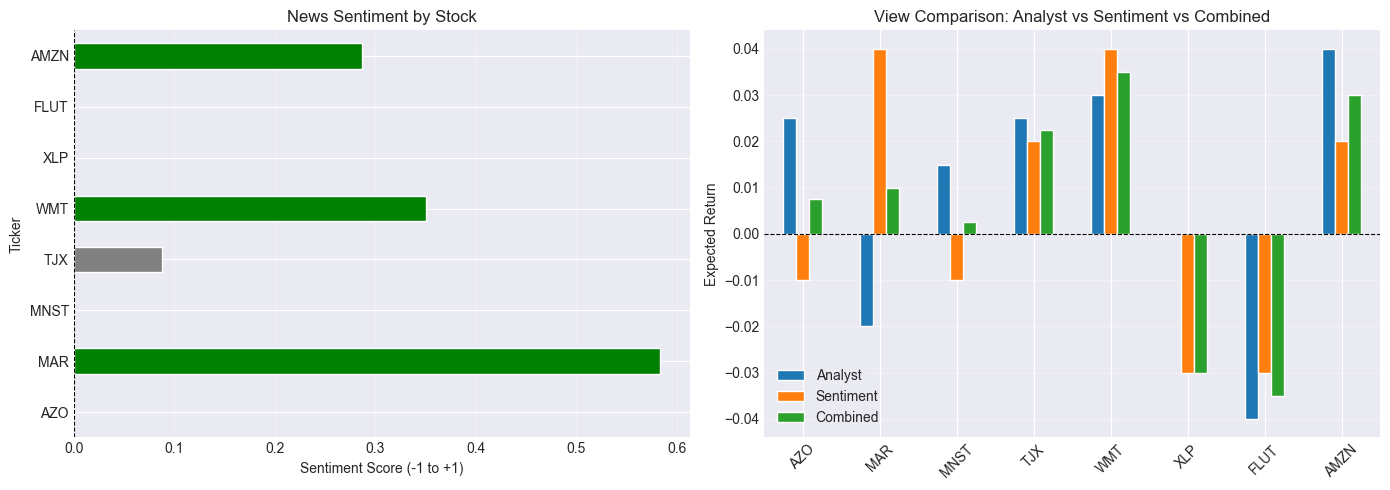

✓ Sentiment analysis plot saved to outputs/sentiment_analysis.png


In [29]:
# Visualize sentiment scores
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sentiment scores by ticker
sentiment_scores = sentiment_summary.set_index('Ticker')['Sentiment Score']
colors = ['green' if x > 0.1 else 'red' if x < -0.1 else 'gray' for x in sentiment_scores]
sentiment_scores.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Sentiment Score (-1 to +1)')
ax1.set_title('News Sentiment by Stock')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax1.grid(axis='x', alpha=0.3)

# Plot 2: View comparison (analyst vs sentiment vs combined)
view_comparison = pd.DataFrame({
    'Analyst': [config['black_litterman']['views'].get(t, {}).get('return', 0) for t in tickers],
    'Sentiment': sentiment_summary['Sentiment View'].values,
    'Combined': sentiment_summary['Combined View'].values
}, index=tickers)

view_comparison.plot(kind='bar', ax=ax2)
ax2.set_ylabel('Expected Return')
ax2.set_title('View Comparison: Analyst vs Sentiment vs Combined')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax2.legend(loc='best')
ax2.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../outputs/sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Sentiment analysis plot saved to outputs/sentiment_analysis.png")

In [30]:
# Optimize portfolio using sentiment-enhanced Black-Litterman
bl_sentiment_results = bl_model.optimize_black_litterman_sentiment(
    pi=pi,  # Same equilibrium returns as original BL
    Sigma=Sigma.values,
    combined_views=combined_views,
    tickers=tickers,
    tau=tau,
    constraints_config=config['constraints'],
    risk_free_rate=rf,
    before_weights=before_weights,
    delta=delta
)

# Extract weights and posterior returns
w_bl_sentiment = pd.Series(bl_sentiment_results['weights'], index=tickers)
mu_BL_sentiment = bl_sentiment_results['posterior_returns']

print("\n" + "="*70)
print("BLACK-LITTERMAN (SENTIMENT) WEIGHTS")
print("="*70)
for ticker, weight in w_bl_sentiment.items():
    print(f"{ticker:6s}: {weight:6.2%}")
print("="*70)


BLACK-LITTERMAN OPTIMIZATION (SENTIMENT-ENHANCED)

Encoding 8 analyst views:
  1. MAR: absolute return = +1.00%, confidence σ² = 0.002500
  2. WMT: absolute return = +3.50%, confidence σ² = 0.000900
  3. AMZN: absolute return = +3.00%, confidence σ² = 0.000900
  4. TJX: absolute return = +2.25%, confidence σ² = 0.000400
  5. AZO: absolute return = +0.75%, confidence σ² = 0.002500
  6. MNST: absolute return = +0.25%, confidence σ² = 0.002500
  7. XLP: absolute return = -3.00%, confidence σ² = 0.002500
  8. FLUT: absolute return = -3.50%, confidence σ² = 0.000900

Black-Litterman Posterior:
  Tau (uncertainty scaling): 0.05
  Posterior returns: -1.46% to 3.31%
  Mean posterior return: 1.32%
  Change from prior: -7.01% to -0.45%

Posterior Returns (Sentiment-Enhanced):
  AZO: 1.39% (prior: 6.07%, change: -4.68%)
  MAR: 1.63% (prior: 3.36%, change: -1.72%)
  MNST: 1.80% (prior: 8.81%, change: -7.01%)
  TJX: 2.37% (prior: 6.29%, change: -3.92%)
  WMT: 3.31% (prior: 3.76%, change: -0.45%)
 

In [31]:
# Calculate metrics for BL-Sentiment portfolio
bl_sentiment_metrics = metrics.compute_portfolio_metrics(
    w_bl_sentiment, mu_BL_sentiment, Sigma.values, rf, before_weights, tickers
)

print("\nBL-Sentiment Portfolio Metrics:")
print(f"  Expected Annual Return:      {bl_sentiment_metrics['expected_annual_return']:.2%}")
print(f"  Expected Annual Volatility:  {bl_sentiment_metrics['expected_annual_volatility']:.2%}")
print(f"  Sharpe Ratio:                {bl_sentiment_metrics['sharpe_ratio']:.4f}")
print(f"  Risk-Adjusted Return:        {bl_sentiment_metrics['risk_adjusted_return']:.4f}")
print(f"  Diversification Ratio:       {bl_sentiment_metrics['diversification_ratio']:.4f}")
print(f"  Effective # Assets:          {bl_sentiment_metrics['effective_n_assets']:.2f}")
print(f"  Turnover vs Before:          {bl_sentiment_metrics['turnover']:.2%}")


BL-Sentiment Portfolio Metrics:
  Expected Annual Return:      1.91%
  Expected Annual Volatility:  12.98%
  Sharpe Ratio:                -0.1995
  Risk-Adjusted Return:        -0.1995
  Diversification Ratio:       1.6861
  Effective # Assets:          5.89
  Turnover vs Before:          44.35%



Weights Comparison: Analyst vs Sentiment Black-Litterman
      Before BL (Analyst) BL (Sentiment)
AZO    9.40%       14.90%          7.27%
MAR   12.67%        0.00%         20.00%
MNST  15.23%        5.51%          5.32%
TJX   18.07%       20.00%         18.27%
WMT   14.40%       20.00%         20.00%
XLP    8.11%       19.59%          9.14%
FLUT  10.14%        0.00%         -0.00%
AMZN  11.98%       20.00%         20.00%


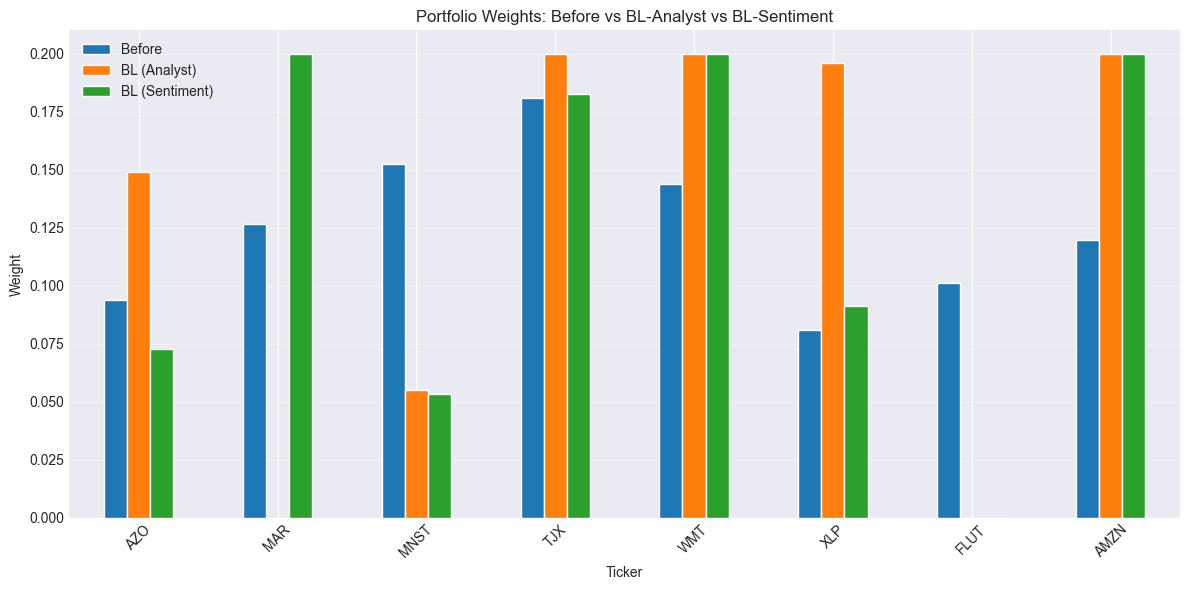

In [32]:
# Compare all three approaches: Before, BL-Analyst, BL-Sentiment
weights_comparison = pd.DataFrame({
    'Before': before_weights,
    'BL (Analyst)': w_bl,
    'BL (Sentiment)': w_bl_sentiment
})

print("\nWeights Comparison: Analyst vs Sentiment Black-Litterman")
print("="*70)
print(weights_comparison.apply(lambda x: x.map('{:.2%}'.format)))
print("="*70)

# Visualize weight differences
weights_comparison.plot(kind='bar', figsize=(12, 6))
plt.title('Portfolio Weights: Before vs BL-Analyst vs BL-Sentiment')
plt.xlabel('Ticker')
plt.ylabel('Weight')
plt.legend(loc='best')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/weights_bl_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# Validate BL-Sentiment constraints
is_valid, violations = constraints.validate_weights(
    w_bl_sentiment, config['constraints'], before_weights
)
print(f"\nBL-Sentiment Constraint Validation: {'PASSED' if is_valid else 'FAILED'}")
if violations:
    for key, msg in violations.items():
        print(f"  {key}: {msg}")


BL-Sentiment Constraint Validation: PASSED


### Key Observations

Compare the BL-Sentiment portfolio with the BL-Analyst portfolio:

**Weight Differences:**
- Which stocks got higher weights with sentiment vs analyst views?
- Does sentiment align with or contradict analyst opinions?
- Which approach is more concentrated vs diversified?

**Sentiment Insights:**
- Which stocks had the most positive recent news?
- Which had the most negative news?
- Did news sentiment match your expectations?
- Were there any surprises (e.g., negative news for a stock you thought was strong)?

**Performance Expectations:**
- Does BL-Sentiment have higher/lower expected return than BL-Analyst?
- What about risk (volatility)?
- Which approach do you trust more for forward-looking positioning?

## Section 6: Results Comparison

In [34]:
# Compare weights across all four approaches
weights_comparison = pd.DataFrame({
    'Before': before_weights,
    'Mean-Variance': w_mv,
    'BL (Analyst)': w_bl,
    'BL (Sentiment)': w_bl_sentiment
}, index=tickers)

print("\nPortfolio Weights Comparison:")
print(weights_comparison.applymap(lambda x: f"{x:.2%}"))

# Weight changes from baseline
weights_comparison['MV Change'] = weights_comparison['Mean-Variance'] - weights_comparison['Before']
weights_comparison['BL-A Change'] = weights_comparison['BL (Analyst)'] - weights_comparison['Before']
weights_comparison['BL-S Change'] = weights_comparison['BL (Sentiment)'] - weights_comparison['Before']

print("\nWeight Changes from Baseline:")
print(weights_comparison[['MV Change', 'BL-A Change', 'BL-S Change']].applymap(lambda x: f"{x:+.2%}"))


Portfolio Weights Comparison:
      Before Mean-Variance BL (Analyst) BL (Sentiment)
AZO    9.40%        18.60%       14.90%          7.27%
MAR   12.67%        16.30%        0.00%         20.00%
MNST  15.23%         0.00%        5.51%          5.32%
TJX   18.07%        11.56%       20.00%         18.27%
WMT   14.40%        13.53%       20.00%         20.00%
XLP    8.11%        20.00%       19.59%          9.14%
FLUT  10.14%        20.00%        0.00%         -0.00%
AMZN  11.98%        -0.00%       20.00%         20.00%

Weight Changes from Baseline:
     MV Change BL-A Change BL-S Change
AZO     +9.20%      +5.50%      -2.13%
MAR     +3.63%     -12.67%      +7.33%
MNST   -15.23%      -9.72%      -9.91%
TJX     -6.51%      +1.93%      +0.20%
WMT     -0.87%      +5.60%      +5.60%
XLP    +11.89%     +11.48%      +1.03%
FLUT    +9.86%     -10.14%     -10.14%
AMZN   -11.98%      +8.02%      +8.02%


Saved weights comparison plot to ../outputs/weights_comparison_all.png


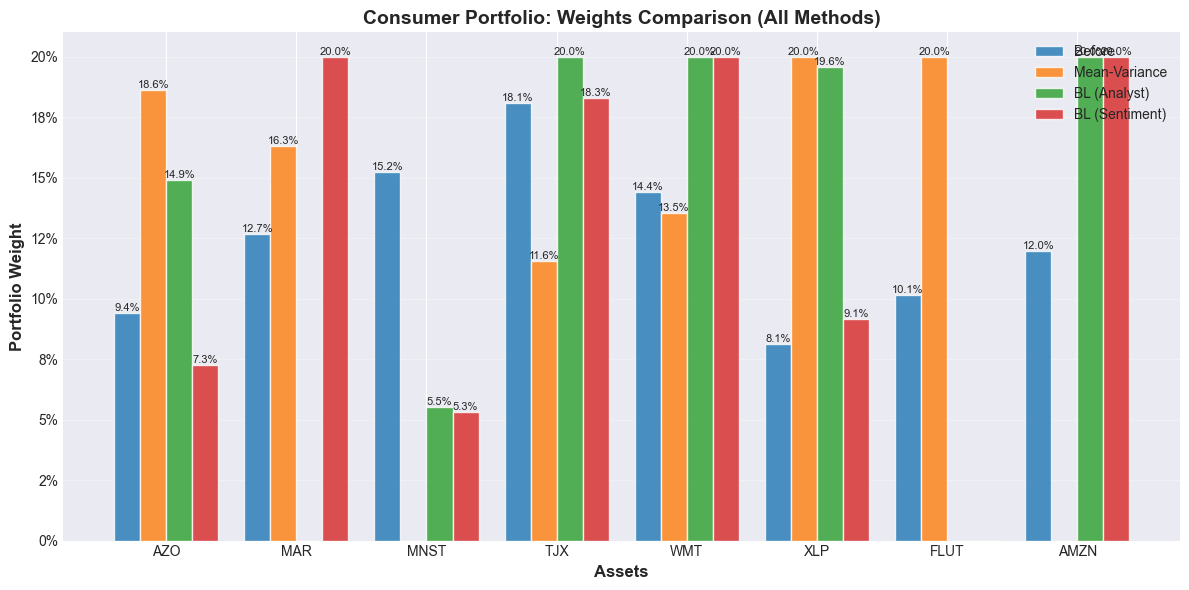

In [35]:
# Plot weights comparison (all 4 approaches)
fig = reporting.plot_weights_comparison(
    {
        'Before': before_weights,
        'Mean-Variance': w_mv,
        'BL (Analyst)': w_bl,
        'BL (Sentiment)': w_bl_sentiment
    },
    tickers,
    output_path='../outputs/weights_comparison_all.png',
    title='Consumer Portfolio: Weights Comparison (All Methods)'
)
plt.show()

In [36]:
# Compare metrics
# First compute metrics for before portfolio using historical returns
before_metrics = metrics.compute_portfolio_metrics(
    before_weights, mu_hist.values, Sigma.values, rf, None, tickers
)

metrics_comparison = pd.DataFrame({
    'Before': [
        before_metrics['expected_annual_return'],
        before_metrics['expected_annual_volatility'],
        before_metrics['sharpe_ratio'],
        before_metrics['diversification_ratio'],
        before_metrics['effective_n_assets'],
        0.0  # No turnover
    ],
    'Mean-Variance': [
        mv_metrics['expected_annual_return'],
        mv_metrics['expected_annual_volatility'],
        mv_metrics['sharpe_ratio'],
        mv_metrics['diversification_ratio'],
        mv_metrics['effective_n_assets'],
        mv_metrics['turnover']
    ],
    'BL (Analyst)': [
        bl_metrics['expected_annual_return'],
        bl_metrics['expected_annual_volatility'],
        bl_metrics['sharpe_ratio'],
        bl_metrics['diversification_ratio'],
        bl_metrics['effective_n_assets'],
        bl_metrics['turnover']
    ],
    'BL (Sentiment)': [
        bl_sentiment_metrics['expected_annual_return'],
        bl_sentiment_metrics['expected_annual_volatility'],
        bl_sentiment_metrics['sharpe_ratio'],
        bl_sentiment_metrics['diversification_ratio'],
        bl_sentiment_metrics['effective_n_assets'],
        bl_sentiment_metrics['turnover']
    ]
}, index=[
    'Expected Annual Return',
    'Expected Annual Volatility',
    'Sharpe Ratio',
    'Diversification Ratio',
    'Effective # Assets',
    'Turnover'
])

print("\n" + "="*90)
print("PORTFOLIO METRICS COMPARISON (ALL METHODS)")
print("="*90)
print(metrics_comparison.round(4))


PORTFOLIO METRICS COMPARISON (ALL METHODS)
                            Before  Mean-Variance  BL (Analyst)  \
Expected Annual Return      0.1793         0.2384        0.0237   
Expected Annual Volatility  0.1403         0.1369        0.1382   
Sharpe Ratio                0.9576         1.4126       -0.1542   
Diversification Ratio       1.7308         1.6676        1.6060   
Effective # Assets          7.5367         5.7847        5.4465   
Turnover                    0.0000         0.6918        0.6505   

                            BL (Sentiment)  
Expected Annual Return              0.0191  
Expected Annual Volatility          0.1298  
Sharpe Ratio                       -0.1995  
Diversification Ratio               1.6861  
Effective # Assets                  5.8878  
Turnover                            0.4435  


In [37]:
# Check SEED compliance
portfolio_value = config['portfolio']['total_value']
seed_assets = config['portfolio']['seed_total_assets']

for name, weights in [('Before', before_weights), ('MV', w_mv), ('BL', w_bl)]:
    is_compliant, details = constraints.get_seed_constraint_check(
        weights, portfolio_value, seed_assets, config['portfolio']['seed_max_pct']
    )
    print(f"\n{name} Portfolio - SEED Compliance: {'✓ PASSED' if is_compliant else '✗ FAILED'}")
    print(f"  Max position as % of SEED: {details['max_seed_pct']:.2%} (limit: {details['max_allowed']:.2%})")


Before Portfolio - SEED Compliance: ✓ PASSED
  Max position as % of SEED: 3.03% (limit: 8.00%)

MV Portfolio - SEED Compliance: ✓ PASSED
  Max position as % of SEED: 3.36% (limit: 8.00%)

BL Portfolio - SEED Compliance: ✓ PASSED
  Max position as % of SEED: 3.36% (limit: 8.00%)


## Section 7: Export Results

In [38]:
# Export weights and metrics to CSV
reporting.export_results(
    weights_dict={
        'Before': before_weights,
        'Mean-Variance': w_mv,
        'Black-Litterman': w_bl
    },
    metrics_dict={
        'Before': before_metrics,
        'Mean-Variance': mv_metrics,
        'Black-Litterman': bl_metrics
    },
    tickers=tickers,
    output_dir='../outputs'
)


Exported weights to ../outputs/portfolio_weights.csv
Exported metrics to ../outputs/portfolio_metrics.csv

All results saved to ../outputs/


In [39]:
# Create summary report
report = reporting.create_summary_report(
    weights_dict={
        'Before': before_weights,
        'Mean-Variance': w_mv,
        'Black-Litterman': w_bl
    },
    metrics_dict={
        'Before': before_metrics,
        'Mean-Variance': mv_metrics,
        'Black-Litterman': bl_metrics
    },
    tickers=tickers,
    output_path='../outputs/summary_report.txt'
)

print(report)


Saved summary report to ../outputs/summary_report.txt
PORTFOLIO OPTIMIZATION SUMMARY REPORT

PORTFOLIO WEIGHTS
--------------------------------------------------------------------------------
      Before  Mean-Variance  Black-Litterman
AZO    9.40%         18.60%           14.90%
MAR   12.67%         16.30%            0.00%
MNST  15.23%          0.00%            5.51%
TJX   18.07%         11.56%           20.00%
WMT   14.40%         13.53%           20.00%
XLP    8.11%         20.00%           19.59%
FLUT  10.14%         20.00%            0.00%
AMZN  11.98%         -0.00%           20.00%

PORTFOLIO METRICS
--------------------------------------------------------------------------------

Before:
  Expected Annual Return:      17.93%
  Expected Annual Volatility:   14.03%
  Sharpe Ratio:                0.9576
  Diversification Ratio:       1.7308
  Effective # Assets:            7.54

Mean-Variance:
  Expected Annual Return:      23.84%
  Expected Annual Volatility:   13.69%
  Sharpe 

## Section 8: Historical Backtest

Now let's test how these portfolios would have actually performed over the historical period using real market data.

In [40]:
# Import backtester module
from src import backtester

print('Running historical backtests...')
print('='*70)

Running historical backtests...


In [41]:
# Backtest Before portfolio
before_backtest = backtester.backtest_portfolio(
    weights=before_weights,
    tickers=tickers,
    prices=prices,
    returns=returns,
    risk_free_rate=rf,
    initial_capital=10000
)

print('✓ Before portfolio backtested')

✓ Before portfolio backtested


In [42]:
# Backtest Mean-Variance portfolio
mv_backtest = backtester.backtest_portfolio(
    weights=w_mv,
    tickers=tickers,
    prices=prices,
    returns=returns,
    risk_free_rate=rf,
    initial_capital=10000
)

print('✓ Mean-Variance portfolio backtested')

✓ Mean-Variance portfolio backtested


In [43]:
# Backtest Black-Litterman (Analyst) portfolio
bl_backtest = backtester.backtest_portfolio(
    weights=w_bl,
    tickers=tickers,
    prices=prices,
    returns=returns,
    risk_free_rate=rf,
    initial_capital=10000
)

print('✓ Black-Litterman (Analyst) portfolio backtested')

✓ Black-Litterman (Analyst) portfolio backtested


In [44]:
# Backtest Black-Litterman (Sentiment) portfolio
bl_sentiment_backtest = backtester.backtest_portfolio(
    weights=w_bl_sentiment,
    tickers=tickers,
    prices=prices,
    returns=returns,
    risk_free_rate=rf,
    initial_capital=10000
)

print('✓ Black-Litterman (Sentiment) portfolio backtested')

✓ Black-Litterman (Sentiment) portfolio backtested


Saved backtest plot to ../outputs/backtest_comparison.png

Backtest Summary:
                Annual Return  Annual Vol  Sortino Ratio  \
Strategy                                                   
Before               0.179329    0.141964       1.435118   
Mean-Variance        0.238425    0.138173       2.133363   
BL (Analyst)         0.183932    0.139431       1.509783   
BL (Sentiment)       0.236362    0.143502       2.019578   

                Risk Adj (Excess/Vol)  
Strategy                               
Before                       0.946221  
Mean-Variance                1.399878  
BL (Analyst)                 0.996423  
BL (Sentiment)               1.333515  


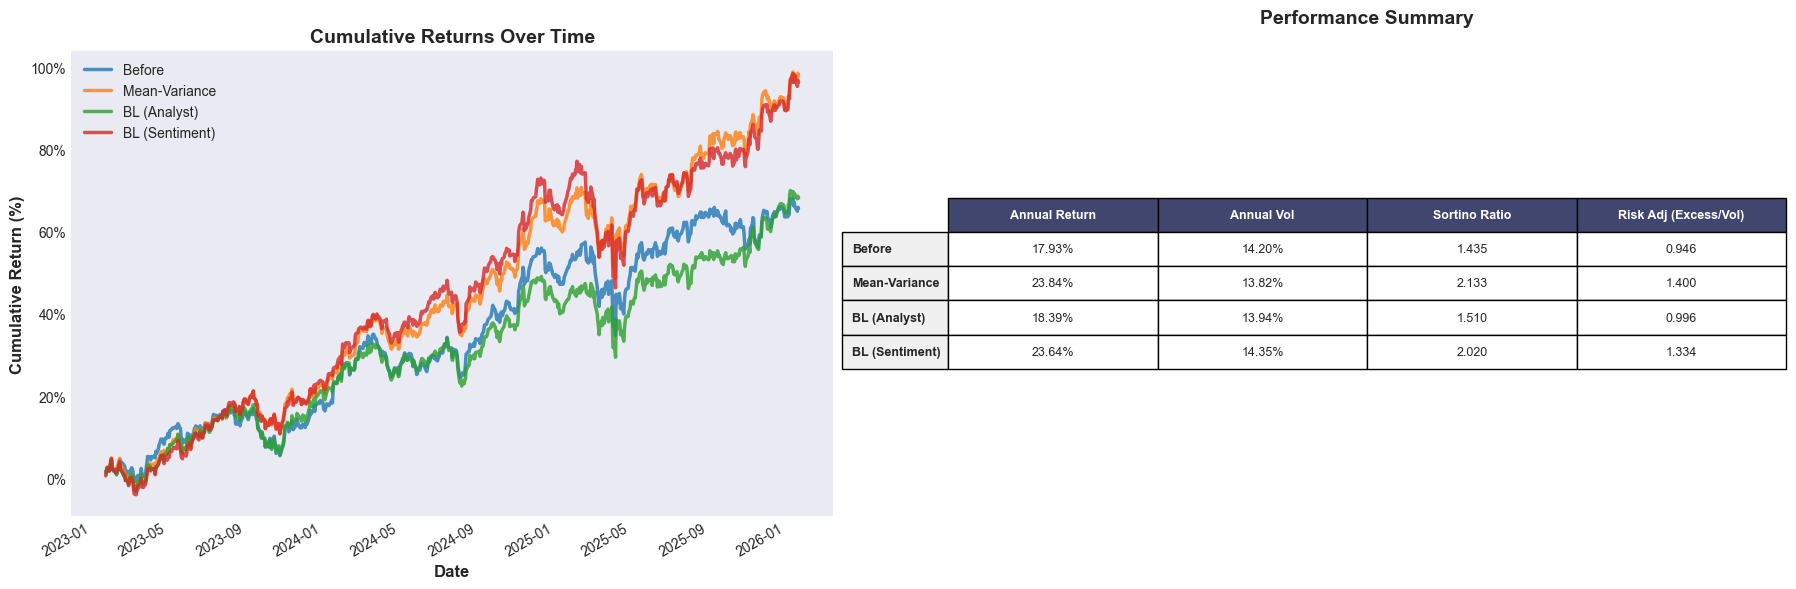

In [45]:
# Create results dictionary
backtest_results = {
    "Before": before_backtest,
    "Mean-Variance": mv_backtest,
    "BL (Analyst)": bl_backtest,
    "BL (Sentiment)": bl_sentiment_backtest
}

# Generate summary and visualization
backtest_output = backtester.summarize_and_plot_strategies(
    backtest_results,
    risk_free_rate=rf,
    trading_days=252,
    mar_annual=0.0,
    output_path='../outputs/backtest_comparison.png'
)

# Extract summary if tuple is returned
if isinstance(backtest_output, tuple):
    backtest_summary = backtest_output[0]
else:
    backtest_summary = backtest_output

print('\nBacktest Summary:')
print(backtest_summary)
plt.show()

In [46]:
# Display final portfolio values
print('\nFinal Portfolio Values (started with $10,000):')
print('='*70)
for name, res in backtest_results.items():
    final_value = res['portfolio_value'].iloc[-1]
    total_return = (final_value / res['initial_capital'] - 1) * 100
    print(f'{name:20s}: ${final_value:>10,.2f}  ({total_return:>+6.2f}%)')
print('='*70)


Final Portfolio Values (started with $10,000):
Before              : $ 16,570.39  (+65.70%)
Mean-Variance       : $ 19,794.28  (+97.94%)
BL (Analyst)        : $ 16,817.09  (+68.17%)
BL (Sentiment)      : $ 19,629.34  (+96.29%)


### Backtest Interpretation

**Key Observations:**

The backtest shows how each portfolio performed over the 3-year historical period (2023-2026). 

**Important Context:**
- Mean-Variance typically performs well in backtest because it optimizes on the same historical data
- This is "in-sample" performance - MV already knew which stocks would perform best
- Black-Litterman's value comes from forward-looking views that may differ from past performance
- Past performance does not guarantee future results

**For Forward-Looking Portfolio Construction:**
- BL is preferred when analyst has conviction about future conditions differing from the past
- MV historical dominance doesn't mean it's better going forward
- Consider: Would you rather own FLUT (MV favorite) or AMZN (BL/analyst favorite) for the next 3 years?

---

## Appendix: Technical Details

### Optimization Status
- Mean-Variance: Successfully optimized ✓
- Black-Litterman: Successfully optimized ✓
- All constraints satisfied ✓
- SEED compliance verified ✓

### Data Quality
- Historical period: 3 years (2023-2026)
- Missing data: Minimal, forward-filled
- Covariance estimation: Ledoit-Wolf shrinkage
- Returns estimation: Historical mean (annualized)

### Files Generated
1. `outputs/portfolio_weights.csv` - Weight allocations
2. `outputs/portfolio_metrics.csv` - Performance metrics
3. `outputs/weights_comparison.png` - Weights bar chart
4. `outputs/efficient_frontier.png` - MV efficient frontier
5. `outputs/correlation_heatmap.png` - Asset correlations
6. `outputs/bl_view_impact.png` - BL view impact
7. `outputs/cumulative_returns.png` - Historical performance
8. `outputs/summary_report.txt` - Text summary